In [134]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population

import torch
import pandas as pd
import random
from matplotlib import pyplot as plt
import networkx as nx

device = "cuda" if torch.cuda.is_available() else "cpu"

class pure_EPI_dense(torch.nn.Module):
    def __init__(self, ISNet, psMatrix, device, train=False, cc=None, recursive=False, sampleAsState=True):
        super(pure_EPI_dense, self).__init__()
        self._n= ISNet.size()[0]
        self._IS= ISNet[None, :]
        self._EE= torch.eye(self._n).to(device)
        self._II= self._EE
        self._RR= self._EE
        self._psMatrix= psMatrix
        self._train= train
        if train==True:
            self._psMatrix=torch.nn.Parameter(psMatrix)
        self._P= None
        self._forceCc=torch.tensor([[0, 1, 0, 0],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1],
                                    [0, 0, 0, 0]], device=device) 
        self._cc= cc
        self._recursive= recursive
        self._softmaxLayer= torch.nn.Softmax(dim=1)
        self._sampleAsState= sampleAsState
    
    def reset_probability(self, population):
        #self._state= torch.stack((population["S"], population["E"], population["I"], population["R"]))
        self._P= None


    def forward(self, state):

        if self._train==False:
            psMatrix= self._psMatrix
        else:
            psMatrix= self.get_psMatrix()
        ps10= torch.zeros_like(state, device=device)#1*4*1000
        #self._ISS= self._IS.repeat( 1, 1, state.shape[0])
        logProbIS= torch.zeros([state.shape[0], self._n, self._n], device=device)
        for i in range(state.shape[0]):
            logProbIS[i, :]= torch.log(1-self._IS*state[None, i, 0].T*state[i, 2]*psMatrix[0, 1])#2*1000*1000, 2*1000, 1000*2!
    
        ps10[:, 1]= 1- torch.exp(torch.sum(logProbIS, dim=2))
        ps10[:, 0]= 1- ps10[:, 1]
        constantM=torch.tensor([[0, 0, 0, 0],
                                [1, 1, 1, 1],
                                [1, 1, 1, 1],
                                [1, 1, 1, 1]], device=device) 
        ps2T= (self._psMatrix*constantM).T
        for i in range(state.shape[0]):
            state[i, :]= state[i, 0, :]*ps10[i, :]+ ps2T.matmul(state[i, :])

        return state, state
    
    def get_population_num(self, state):

        return torch.sum(state, 2)

    #sample nxm pobability matrix, of 0 dimension, which contains n choise for a random variable
    def sample_uniform_matrix(self, P):  
        state= torch.zeros_like(P, device=device)
        U= torch.rand(self._n).to(device)
        for i in range(P.size()[0]):
            U= U- P[i]
            state[i]= U<0
            U= U+state[i]
        return state
    
    def get_population_dir(self, state):
        return { #a columnar DB somewhat reminds the Pandas DataFrame 
                "S": state[0],
                "E": state[1],
                "I": state[2],
                "R": state[3],
                }
    
    def get_probability(self):
        return self._P
    
    def get_probability_transition_matrix(self):
        
        return self._psMatrix
    
    def get_psMatrix(self):
        #psMatrix= torch.sigmoid(self._psMatrix)
        psMatrix= self._softmaxLayer(self._psMatrix)
        psMatrix= psMatrix*self._forceCc
        if self._cc is not None:
                psMatrix= psMatrix*self._cc
        return psMatrix

In [135]:
def sim(timeHorizon, model: pure_EPI_dense, state):
  populationNumber= []
  states = [state]
  for _ in range(timeHorizon):
    state, _= model(state)
    populationNumber.append(model.get_population_num(state))
    states.append(state)
  populationNumber = torch.stack(populationNumber)
  states = torch.stack(states)
  return populationNumber, states

In [146]:
n= 500
avgDegree= 6
timeHorizon= 5
print("haha")
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
print("haha")
contact = contact.requires_grad_(True)
ps=     torch.tensor([[0.7, 0.3, 0, 0],
                      [0, 0.5, 0.5, 0],
                      [0, 0, 0.95, 0.05],
                      [0, 0, 0, 1]], device=device)
state= create_population.population(n, device)
state= torch.stack([state, state])
model=pure_EPI_dense(contact, ps, device=device)

haha
haha


In [148]:
realNumber, _= sim(50, model=model, state=state)
realNumber= realNumber[:, 0, :]

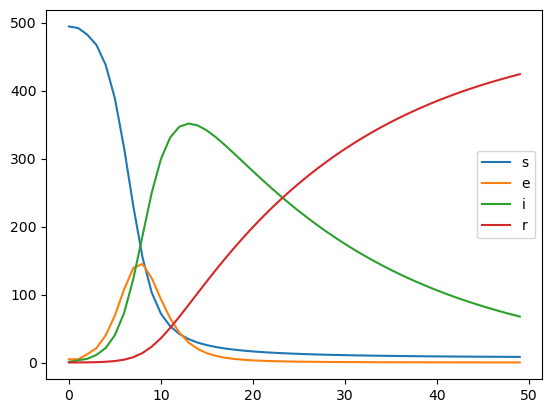

In [149]:
plotRealNumber= realNumber.squeeze().cpu().detach()
plt.plot(plotRealNumber, label=["s", "e", "i", "r"])
plt.legend()